In [1]:
# all imports
import pandas as pd
import numpy as np
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from math import sqrt
from linearmodels import PanelOLS
import os.path
import pickle
from linearmodels import PanelOLS, PooledOLS, RandomEffects, FamaMacBeth, BetweenOLS, FirstDifferenceOLS
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy.linalg as la
from scipy import stats
import scipy
from statsmodels.tools.tools import chain_dot
from statsmodels.tools.decorators import cache_readonly
from statsmodels.regression.linear_model import (RegressionModel, RegressionResults)
import warnings
warnings.filterwarnings("ignore")

/home/saubhik.mukherjee/.local/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


# Create PoC segment data

In [2]:
if os.path.isfile("bar_data.csv"):
    bar_data = pd.read_csv("bar_data.csv", index_col=0)
else:
    # Read data
    data = pd.read_csv("Training Data_PERPOC.csv")

    # Let's do the analysis for 'Bar'
    bar_data = data.loc[data['SEGMENT_POC'] == 'Bar'].copy()

    # Choose the right features
    features = ['YEAR', 'MONTH', 'DAY', 'COD_POC', 'SEGMENT_POC', 'DISCOUNT',
               'COUNTPOC', 'COD_PROD', 'FACTOR_HL', 'COD_ACOB', 'COD_COMBO',
               'COD_ACAO', 'WEEKOFMONTH', 'DAYOFWEEK', 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
               'POL_PTR', 'VOLPRODDAY', 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
               'HUMAVG', 'PRECIP', 'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
               'TEMPMAX_D-2', 'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
               'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
               'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
               'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
               'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
               'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
               'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
               'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
               'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
               'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
               'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
               'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
               'UNEMPLOYMENTRATE_m-1', 'REPASSE', 'REPASSE+1', 'REPASSE-1']

    # Create a `DATE` column
    bar_data.insert(0, 'DATE', pd.to_datetime(bar_data[['YEAR', 'MONTH', 'DAY']]))

    # Create a `PTR` column, which takes into account the discount
    bar_data["PTR"] = bar_data["POL_PTR"] * (1 + bar_data["DISCOUNT"])

    # Sort the data set on the basis of time
    bar_data.sort_values(['YEAR', 'MONTH', 'DAY'], ascending=[True, True, True], inplace=True)

    # Create `MONTH` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["MONTH"], prefix="MONTH")], axis=1)

    # Create `WEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["WEEKOFMONTH"], prefix="WEEK")], axis=1)

    # Create `DAYOFWEEK` dummies
    bar_data = pd.concat([bar_data, pd.get_dummies(bar_data["DAYOFWEEK"], prefix="DAYOFWEEK")], axis=1)

    # Create `NEARWEEKEND` dummy
    bar_data["NEARWEEKEND"] = bar_data["DAYOFWEEK_0"] | bar_data["DAYOFWEEK_6"] | bar_data["DAYOFWEEK_5"] | bar_data["DAYOFWEEK_4"]

    # Create `VOLPRODDAYWEEKSKU` across all PoCs
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_PROD"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_PROD"], suffixes=["", "WEEKSKU"])

    # Create `VOLPRODDAYWEEK` for each PoC
    vol_sku_week = bar_data.groupby(["MONTH", "WEEKOFMONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=vol_sku_week, how="left", on=["MONTH", "WEEKOFMONTH", "COD_POC"], suffixes=["", "WEEK"])

    # Perform log transforms for the volumes
    bar_data["LOG_VOLPRODDAY"] = np.log(bar_data["VOLPRODDAY"])
    bar_data["LOG_VOLPRODDAYWEEK"] = np.log(bar_data["VOLPRODDAYWEEK"])
    bar_data["LOG_VOLPRODDAYWEEKSKU"] = np.log(bar_data["VOLPRODDAYWEEKSKU"])

    # Perform log tranform for PTR
    bar_data["LOG_PTR"] = np.log(bar_data["PTR"])
    bar_data["LOG_POL_PTR"] = np.log(bar_data["POL_PTR"])

    # Create `DAYSINMONTH`
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"].isin([1, 3, 5, 7, 8, 10, 12]), 31, 30)
    bar_data["DAYSINMONTH"] = np.where(bar_data["MONTH"] == 2, 28, bar_data["DAYSINMONTH"])

    # Create a `POC_STOCK` column for each PoC
    # Get the assumed mean daily sales, when I assume every month, `total sales` = `total purchase`
    monthly_sales = bar_data.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    bar_data = bar_data.merge(right=monthly_sales, how="left", on=["YEAR", "MONTH", "COD_POC"], suffixes=["", "_MEAN"])
    bar_data["VOLPRODDAY_MEAN"] /= bar_data["DAYSINMONTH"]

    # Get the `SALESTODATE`, which is according to our "monthly" assumption
    bar_data["SALESTODATE"] = bar_data["VOLPRODDAY_MEAN"] * bar_data["DAY"]

    # Get the `PURCHASETODATE`
    daily_purchase = bar_data.groupby(["YEAR", "MONTH", "DAY", "COD_POC"])["VOLPRODDAY"].agg('sum').reset_index()
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["YEAR", "MONTH", "COD_POC"])["VOLPRODDAY"].apply(lambda x: x.cumsum()).values
    daily_purchase["PURCHASETODATE"] = daily_purchase.groupby(["COD_POC"])["PURCHASETODATE"].apply(lambda x: x.shift(1))
    daily_purchase = daily_purchase.sort_values(["COD_POC", "YEAR", "MONTH", "DAY"]).reset_index()

    # Set the first entry in `PURCHASETODATE` for every month to 0
    for i in range(1, daily_purchase.shape[0]):
        if i == 1:
            daily_purchase.loc[i - 1, "PURCHASETODATE"] = 0

        if ((daily_purchase["MONTH"][i - 1] != daily_purchase["MONTH"][i]) or 
            (daily_purchase["COD_POC"][i - 1] != daily_purchase["COD_POC"][i])):
            daily_purchase.loc[i, "PURCHASETODATE"] = 0

    # Merge to POC data
    bar_data = bar_data.merge(right=daily_purchase, how="left", on=["YEAR", "MONTH", "DAY", "COD_POC"], suffixes=["", "_DAILY"])

    # Create the `POC_STOCK` column
    bar_data["POC_STOCK"] = bar_data["PURCHASETODATE"] - bar_data["SALESTODATE"]
    
    # Save the bar_data for future use
    bar_data.to_csv("bar_data.csv")

# Modelling Pipeline

In [3]:
def generate_sku_data():
    sku_data = bar_data[bar_data["COD_PROD"] == cod_prod]

    # Let's remove the outliers
    ptr_cap_lo, ptr_cap_hi = np.percentile(a=sku_data["PTR"], q=[1, 99])
    vol_cap_lo, vol_cap_hi = np.percentile(a=sku_data["VOLPRODDAY"], q=[1, 99])
    sku_data = sku_data[(sku_data["PTR"] < ptr_cap_hi) & (sku_data["PTR"] > ptr_cap_lo) & (sku_data["VOLPRODDAY"] < vol_cap_hi) & (sku_data["VOLPRODDAY"] > vol_cap_lo)]

    # Let's remove the PoCs that don't record much change in volume
    vol_var = sku_data.groupby(["COD_POC"])["VOLPRODDAY"].apply(np.var).reset_index()
    sku_data = sku_data.merge(right=vol_var, how="left", on=["COD_POC"], suffixes=["", "_VAR"])
    sku_data = sku_data[sku_data["VOLPRODDAY_VAR"] != 0.]

    # Create dataset
    # First sort data by COD_POC
    sku_data = sku_data.sort_values(["COD_POC", "YEAR", "MONTH", "DAY"]).reset_index()
    sku_data["TIME"] = 1
    for i in range(1, sku_data.shape[0]):
        if sku_data.loc[i - 1, "DATE"] == sku_data.loc[i, "DATE"]:
            sku_data.loc[i, "TIME"] = sku_data.loc[i - 1, "TIME"] + 1
    # Create final time index        
    sku_data["TIME"] = sku_data["DATE"] + "-" + sku_data["TIME"].astype(str)
    sku_data["TIME"] = sku_data.TIME.astype("category").cat.codes
    sku_data.set_index(["COD_POC", "TIME"], inplace=True)
    return sku_data

In [4]:
# SOURCE: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python
def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [5]:
def get_training_set():
    
    features = [
                 # Engineered features
                 "POC_STOCK",
                 "LOG_PTR",
                 # "LOG_POL_PTR",
                 # 'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7', 'MONTH_11', 'MONTH_12',
                 # "WEEK_1", "WEEK_2", "WEEK_3", "WEEK_4", "WEEK_5",
                 # "DAYOFWEEK_0", "DAYOFWEEK_1", "DAYOFWEEK_2", "DAYOFWEEK_3", "DAYOFWEEK_4", "DAYOFWEEK_5",
                 "NEARWEEKEND",
                 "LOG_VOLPRODDAYWEEK",
                 "LOG_VOLPRODDAYWEEKSKU",

                 # All features which were already present   
                 # 'COD_POC', 
                 # 'DISCOUNT',
                 'COUNTPOC', 
                 # 'COD_PROD', 
                 # 'FACTOR_HL', 
                 # 'COD_ACOB', 'COD_COMBO', 'COD_ACAO', 
                 # 'WEEKOFMONTH', 
                 # 'DAYOFWEEK', 
                 'SAZ_MX', 'SAZ_DWX', 'SAZ_WMX',
                 # 'POL_PTR', 
                 'SUMMER', 'TEMPMAX', 'TEMPMIN', 'TEMPAVG',
                 'HUMAVG', 'PRECIP', 
                 #'TEMPMAX_D+1', 'TEMPMAX_D-1', 'TEMPMAX_D+2',
                 #'TEMPMAX_D-2', 
                 #'TEMPMAX_D+3', 'TEMPMAX_D-3', 'TEMPMIN_D+1',
                 #'TEMPMIN_D-1', 'TEMPMIN_D+2', 'TEMPMIN_D-2', 'TEMPMIN_D+3',
                 #'TEMPMIN_D-3', 'TEMPAVG_D+1', 'TEMPAVG_D-1', 'TEMPAVG_D+2',
                 #'TEMPAVG_D-2', 'TEMPAVG_D+3', 'TEMPAVG_D-3', 'HUMAVG_D+1', 'HUMAVG_D-1',
                 #'HUMAVG_D+2', 'HUMAVG_D-2', 'HUMAVG_D+3', 'HUMAVG_D-3', 'PRECIP_D+1',
                 #'PRECIP_D-1', 'PRECIP_D+2', 'PRECIP_D-2', 'PRECIP_D+3', 'PRECIP_D-3',
                 'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
                 'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
                 'SPECIAL_DATE_D-3', 'ICC', 'ICEA', 'INEC', 'INPC', 'INPC_AB', 'IPCA',
                 'IPCA_AB', 'AVERAGEYIELD', 'SELIC_MONTH', 'UNEMPLOYMENTRATE', 'ICC_m-1',
                 'ICEA_m-1', 'INEC_m-1', 'INPC_m-1', 'INPC_AB_m-1', 'IPCA_m-1',
                 'IPCA_AB_m-1', 'AVERAGEYIELD_m-1', 'SELIC_MONTH_m-1',
                 'UNEMPLOYMENTRATE_m-1', 

                 'REPASSE', 'REPASSE+1', 'REPASSE-1'
               ]
    
    model_data = generate_sku_data()
    
    y = model_data["LOG_VOLPRODDAY"]

    X = model_data[features]
    
    # Remove features which have low variance - using Variance Thresholding
    selector = VarianceThreshold(threshold=1e-03)
    selector.fit(X)
    X = X.loc[:, selector.get_support()]

    # Feature pre-processing
    # TODO: Get the maximum occurring categories
    
    # Apply power transform
    pt = PowerTransformer()
    X = pd.DataFrame(pt.fit_transform(X), columns=X.columns, index=X.index)
    X["LOG_PTR"] = model_data["LOG_PTR"]
    
    # Use VIF threshold to remove highly correlated features
    X = calculate_vif(X)

    return (X, y)


def run_model(y, X):
    X = sm.add_constant(X)
    
    # Random Effects
    model = RandomEffects(y, X)
    results = model.fit()
    
    # Panel OLS with Fixed Effects
    # model = PanelOLS(y, X, entity_effects=True)
    # results = model.fit(cov_type="heteroskedastic")

    return (model, results)


def model_selection(X, y):
    # Best Subset Selection &
    # Forward & Backward Stepwise Selection
    # source = "http://www.science.smith.edu/~jcrouser/SDS293/labs/2016/lab8/Lab%208%20-%20Subset%20Selection%20in%20Python.pdf"
    
    
    def process_subset(feature_set):
        # Fit model on feature set
        model, results = run_model(y, X[list(feature_set)])
        value = results.rsquared
        # rss = ((results.predict(X[list(feature_set)]) - y) ** 2).sum()
        return {"model": results, "rsquared": value}


    def get_best(k):
        tic = time.time()
        results = []
        for combo in itertools.combinations(X.columns, k):
            results.append(process_subset(list(combo)))
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", k + 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def forward(predictors):
        remaining_predictors = [p for p in X.columns if p not in predictors]
        tic = time.time()
        results = []
        for p in remaining_predictors:
            try:    
                results.append(process_subset(predictors + [p]))
            except:
                continue
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", len(predictors) + 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def backward(predictors):
        tic = time.time()
        results = []
        for combo in itertools.combinations(predictors, len(predictors) - 1):
            try:
                results.append(process_subset(combo))
            except:
                continue
        models = pd.DataFrame(results)
        best_model = models.loc[models["rsquared"].idxmax()]
        toc = time.time()
        print("Processed", models.shape[0], "models on", len(predictors) - 1, "predictors in", toc - tic, "seconds.")
        return best_model


    def forward_stepwise_selection():
        models = pd.DataFrame(columns=["rsquared", "model"])
        tic = time.time()
        predictors = []
        for i in range(1, len(X.columns) + 1):
            try:
                models.loc[i] = forward(predictors)
                predictors = models.loc[i]["model"].model.exog.vars.copy()
                if "const" in predictors:
                    predictors.remove("const")
            except:
                continue
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models, predictors


    def backward_stepwise_selection(predictors=X.columns):
        models = pd.DataFrame(columns=["rsquared", "model"], index=range(1, len(predictors)))
        tic = time.time()
        while len(predictors) > 1:
            try:
                models.loc[len(predictors) - 1] = backward(predictors)
                predictors = models.loc[len(predictors) - 1]["model"].model.exog.vars.copy()
                if "const" in predictors:
                    predictors.remove("const")
            except:
                continue
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models


    def best_subset_selection(till):
        models = pd.DataFrame(columns=["rsquared", "model"])
        tic = time.time()
        for i in range(1, till + 1):
            models.loc[i] = get_best(i)
        toc = time.time()
        print("Total elapsed time:", toc - tic, "seconds.")
        return models


    models_forward, predictors = forward_stepwise_selection()
    models_backward = backward_stepwise_selection(predictors)

    # Find the `best` models, on basis of ajusted R squared
    k_forward = models_forward.apply(lambda row: row[1].rsquared, axis=1).idxmax()
    k_backward = models_backward.apply(lambda row: row[1].rsquared, axis=1).idxmax()
    best_model_forward = models_forward.loc[k_forward, "model"]
    best_model_backward = models_backward.loc[k_backward, "model"]
    
    if best_model_forward.rsquared > best_model_backward.rsquared:
        best_model = best_model_forward
    else:
        best_model = best_model_backward

    return best_model


def iterative_feature_elimination(X, y, features, threshold_pvalue=0.10):
    iteration = 0
    while True:

        print("Iteration: %d" % (iteration))
        iteration += 1
        
        if "const" in features:
            features.remove("const") 

        # Run model
        model, results = run_model(y, X[features])
        
        print("R squared is", results.rsquared)
        
        max_pvalue = max(results.pvalues[results.pvalues.index != "const"])
        if max_pvalue <= threshold_pvalue:
            break
        
        feature_removed = results.pvalues.index[results.pvalues == max_pvalue].tolist()[0]
        print("Feature removed is ", end="")
        print(feature_removed, end="\n\n")
        features.remove(feature_removed)
        
    return results


def run_pipeline():
    
    # File name
    filename = "model_" + str(cod_prod) + ".pkl"
    
    # Make training data
    X, y = get_training_set()

    # Run model selection
    model = model_selection(X=X, y=y)

    # Save the model
    with open(filename, "wb") as f:
        pickle.dump(model.model, f)

    # Run iterative feature elimination to eliminate non-significant features
    model_features = model.model.exog.vars.copy()
    model = iterative_feature_elimination(X=X, y=y, threshold_pvalue=0.01, features=model_features)

    # Print the model summary
    print(model)

    # Save the model
    with open(filename, "wb") as f:
        pickle.dump(model.model, f)

    print("Done!")

In [6]:
# Run for all SKUs in bar_data
# for cod_prod in bar_data["COD_PROD"].unique():
#     if (cod_prod == 9886) or (cod_prod == 90696):
#         continue
#     print("Running for Product " + str(cod_prod) + "...")
#     model = run_pipeline()

cod_prod = 16956
print("Running for Product " + str(cod_prod) + "...")
model = run_pipeline()

Running for Product 16956...
dropping 'COUNTPOC' at index: 5
dropping 'SAZ_MX' at index: 5
dropping 'SUMMER' at index: 7
dropping 'ICC' at index: 19
dropping 'ICEA' at index: 19
dropping 'INEC' at index: 19
dropping 'INPC' at index: 19
dropping 'INPC_AB' at index: 19
dropping 'IPCA' at index: 19
dropping 'IPCA_AB' at index: 19
dropping 'SELIC_MONTH_m-1' at index: 30
dropping 'UNEMPLOYMENTRATE' at index: 21
dropping 'INPC_AB_m-1' at index: 25
dropping 'TEMPAVG' at index: 9
dropping 'AVERAGEYIELD' at index: 18
dropping 'ICEA_m-1' at index: 20
dropping 'IPCA_m-1' at index: 22
dropping 'TEMPMIN' at index: 8
Remaining variables:
Index(['POC_STOCK', 'LOG_PTR', 'NEARWEEKEND', 'LOG_VOLPRODDAYWEEK',
       'LOG_VOLPRODDAYWEEKSKU', 'SAZ_DWX', 'SAZ_WMX', 'TEMPMAX', 'HUMAVG',
       'PRECIP', 'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
       'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
       'SPECIAL_DATE_D-3', 'SELIC_MONTH', 'ICC_m-1', 'INEC_m-1', 'INPC_m-1',
       '

Done!


# Select Model for SKU

In [6]:
# Test only univariable result, to test elasticity
cod_prod = 16956
X, y = get_training_set()
# model_data = generate_sku_data()

dropping 'COUNTPOC' at index: 5
dropping 'SAZ_MX' at index: 5
dropping 'SUMMER' at index: 7
dropping 'ICC' at index: 19
dropping 'ICEA' at index: 19
dropping 'INEC' at index: 19
dropping 'INPC' at index: 19
dropping 'INPC_AB' at index: 19
dropping 'IPCA' at index: 19
dropping 'IPCA_AB' at index: 19
dropping 'SELIC_MONTH_m-1' at index: 30
dropping 'UNEMPLOYMENTRATE' at index: 21
dropping 'INPC_AB_m-1' at index: 25
dropping 'TEMPAVG' at index: 9
dropping 'AVERAGEYIELD' at index: 18
dropping 'ICEA_m-1' at index: 20
dropping 'IPCA_m-1' at index: 22
dropping 'TEMPMIN' at index: 8
Remaining variables:
Index(['POC_STOCK', 'LOG_PTR', 'NEARWEEKEND', 'LOG_VOLPRODDAYWEEK',
       'LOG_VOLPRODDAYWEEKSKU', 'SAZ_DWX', 'SAZ_WMX', 'TEMPMAX', 'HUMAVG',
       'PRECIP', 'SPECIAL_DATE', 'SPECIAL_DATE_D+1', 'SPECIAL_DATE_D-1',
       'SPECIAL_DATE_D+2', 'SPECIAL_DATE_D-2', 'SPECIAL_DATE_D+3',
       'SPECIAL_DATE_D-3', 'SELIC_MONTH', 'ICC_m-1', 'INEC_m-1', 'INPC_m-1',
       'IPCA_AB_m-1', 'AVERAGEYIELD_m

In [16]:
def select_model(y, X):
    
    # FirstDifferenceOLS
    # Do not add constant to first difference OLS
    model = FirstDifferenceOLS(y, X)
    results = model.fit(cov_type="heteroskedastic")
    params = pd.Series(results.params, index=X.columns)
    pvalues = pd.Series(results.pvalues, index=X.columns)
    print("FirstDifferenceOLS gives", results.params["LOG_PTR"], "with pvalue of", results.pvalues["LOG_PTR"], "and", results.rsquared, "fit")
    
    # BetweenOLS
    model = BetweenOLS(y, sm.add_constant(X))
    results = model.fit(cov_type="heteroskedastic")
    params = pd.Series(results.params, index=X.columns)
    pvalues = pd.Series(results.pvalues, index=X.columns)
    print("BetweenOLS gives", results.params["LOG_PTR"], "with pvalue of", results.pvalues["LOG_PTR"], "and", results.rsquared, "fit")
    
    # Random Effects
    model = RandomEffects(y, sm.add_constant(X))
    results = model.fit()
    params = pd.Series(results.params, index=X.columns)
    pvalues = pd.Series(results.pvalues, index=X.columns)
    print("Random Effects gives", results.params["LOG_PTR"], "with pvalue of", results.pvalues["LOG_PTR"], "and", results.rsquared, "fit")
    
    # PanelOLS
    # Do not add constant to fixed effects model
    model = PanelOLS(y, X, entity_effects=True)
    results = model.fit(cov_type="heteroskedastic")
    params = pd.Series(results.params, index=X.columns)
    pvalues = pd.Series(results.pvalues, index=X.columns)
    print("PanelOLS gives", results.params["LOG_PTR"], "with pvalue of", results.pvalues["LOG_PTR"], "and", results.rsquared, "fit")
    
    # PooledOLS
    model = PooledOLS(y, sm.add_constant(X))
    results = model.fit(cov_type="heteroskedastic")
    params = pd.Series(results.params, index=X.columns)
    pvalues = pd.Series(results.pvalues, index=X.columns)
    print("PooledOLS gives", results.params["LOG_PTR"], "with pvalue of", results.pvalues["LOG_PTR"], "and", results.rsquared, "fit")
    
    return None

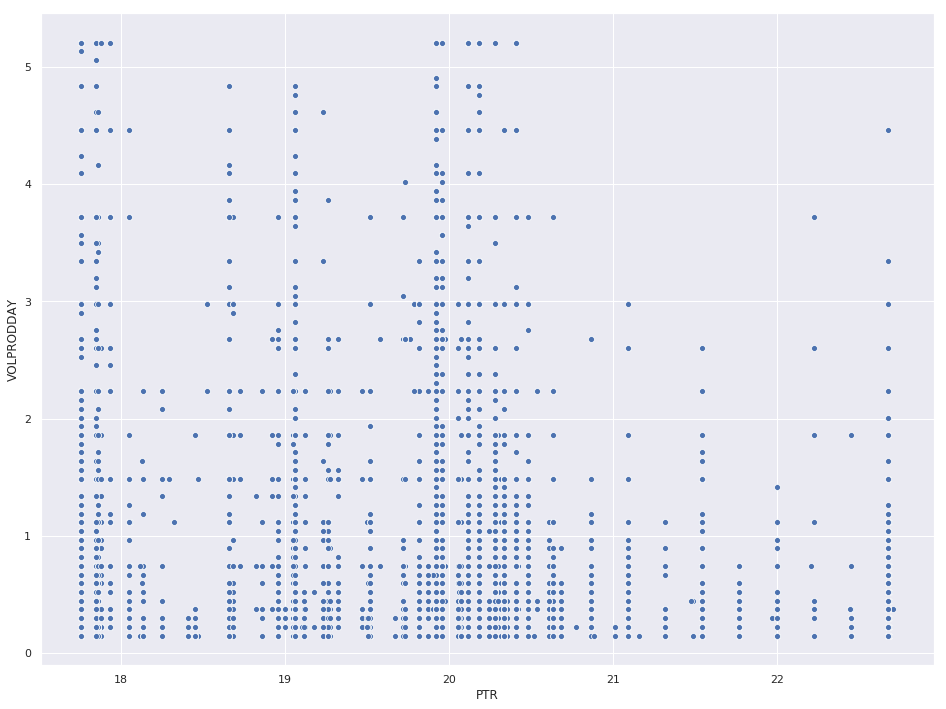

In [51]:
sns.set(rc={'figure.figsize':(16, 12)}) # (11.7,8.27) before
sns.scatterplot(x=model_data["PTR"], y=model_data["VOLPRODDAY"])

# More additions

##### TODO:Add Hausman Test for fe vs re
[Source](https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py)

In [8]:
class Group():
    def __init__(self, index_pandas=None, index_list=None):
        '''
        index_pandas pandas (multi-)index
        index_list list of arrays, pandas series or lists, all of which are
            of length nobs 
        '''
        if index_list != None:
            try:
                tup = zip(*args)
                self.index = pd.MultiIndex.from_tuples(tup)
            except:
                raise Exception("index_list must be a list of lists, pandas series, \
                        or numpy arrays, each of identitcal length nobs.") 
        else:
            self.index = index_pandas
        self.nobs = len(self.index)
        self.slices = None

    def get_slices(self):
        '''Only works on first index level'''
        groups = self.index.get_level_values(0).unique()
        self.slices = [self.index.get_loc(x) for x in groups]

    def count_categories(self, level=0):
        self.counts = np.bincount(self.index.labels[level])

    def transform_dataframe(self, dataframe, function, level=0):
        '''Apply function to each column, by group
        Assumes that the dataframe already has a proper index'''
        if dataframe.shape[0] != self.nobs:
            raise Exception('dataframe does not have the same shape as index')
        out = dataframe.groupby(level=level).apply(function)
        if 1 in out.shape:
            return np.ravel(out)
        else:
            return np.array(out)
     
    def transform_array(self, array, function, level=0):
        '''Apply function to each column, by group'''
        if array.shape[0] != self.nobs:
            raise Exception('array does not have the same shape as index')
        dataframe = pd.DataFrame(array, index=self.index)
        return self.transform_dataframe(dataframe, function, level=level)

    def transform_slices(self, array, function,  **kwargs):
        '''Assumes array is a 1D or 2D numpy array'''
        if array.shape[0] != self.nobs:
            raise Exception('array does not have the same shape as index')
        if self.slices == None:
            self.get_slices()
        processed = []
        for s in self.slices:
            if array.ndim == 2:
                subset = array[s,:]
            elif array.ndim == 1:
                subset = array[s]
            processed.append(function(subset, s, **kwargs))
        return np.concatenate(processed)

    def dummy_sparse(self, level=0):
        '''create a sparse indicator from a group array with integer labels
        Parameters
        ----------
        groups: ndarray, int, 1d (nobs,) an array of group indicators for each
            observation. Group levels are assumed to be defined as consecutive
            integers, i.e. range(n_groups) where n_groups is the number of
            group levels. A group level with no observations for it will still
            produce a column of zeros.
        Returns
        -------
        indi : ndarray, int8, 2d (nobs, n_groups)
            an indicator array with one row per observation, that has 1 in the
            column of the group level for that observation
        Examples
        --------
        >>> g = np.array([0, 0, 2, 1, 1, 2, 0])
        >>> indi = dummy_sparse(g)
        >>> indi
        <7x3 sparse matrix of type '<type 'numpy.int8'>'
            with 7 stored elements in Compressed Sparse Row format>
        >>> indi.todense()
        matrix([[1, 0, 0],
                [1, 0, 0],
                [0, 0, 1],
                [0, 1, 0],
                [0, 1, 0],
                [0, 0, 1],
                [1, 0, 0]], dtype=int8)
        current behavior with missing groups
        >>> g = np.array([0, 0, 2, 0, 2, 0])
        >>> indi = dummy_sparse(g)
        >>> indi.todense()
        matrix([[1, 0, 0],
                [1, 0, 0],
                [0, 0, 1],
                [1, 0, 0],
                [0, 0, 1],
                [1, 0, 0]], dtype=int8)
        '''
        
        groups = self.index.labels[level]
        indptr = np.arange(len(groups)+1)
        data = np.ones(len(groups), dtype=np.int8)
        self.dummies = scipy.sparse.csr_matrix((data, groups, indptr))

class PanelLM(RegressionModel):
    def __init__(self, endog, exog, method='pooling', effects='oneway',
                 unit=None, time=None, hasconst=None, **kwargs):
        if (time != None) and (unit != None):
            self.groupings = Group(index_list=[unit, time])
        else:
            self.groupings = Group(index_pandas=endog.index)
        self.endog = endog
        self.exog = exog
        self.method = method
        self.effects = effects
        if method == 'swar':
            self.var_u, self.var_e, self.theta = swar_ercomp(self.endog, self.exog)
        super(PanelLM, self).__init__(endog, exog, **kwargs)

    def initialize(self, unit=None, time=None):
        self.wexog = self.whiten(self.exog)
        self.wendog = self.whiten(self.endog)
        self.nobs = float(self.wexog.shape[0])
        self.rank = np.rank(self.exog)
        self.df_model = float(self.rank - self.k_constant)
        if self.method == 'within':
            self.df_resid = self.nobs - self.rank - self.groupings.index.levshape[0]
        else:
            self.df_resid = self.nobs - self.rank - 1
        self.df_model = float(self.rank - self.k_constant)

    def whiten(self, data):
        g = self.groupings
        if self.method == 'within':
            f = lambda x: x - x.mean()
            if (self.effects == 'oneway') or (self.effects == 'unit'):
                out = g.transform_array(data, f, 0)
                return out
            elif (self.effects == 'time'):
                out = g.transform_array(data, f, 1)
                return out
            elif (self.effects == 'twoways'):
                out = g.transform_array(data, f, 0)
                out = g.transform_array(data, f, 1)
                return out
            else:
                raise Exception('Method must be unit, time, oneway, or twoways')
        elif self.method == 'between':
            f = lambda x: x.mean()
            out = g.transform_array(data, f, 0)
            return out
        elif self.method == 'fd':
            f = lambda x: (x - x.shift(1))[1:],
            out = g.transform_array(data, f, 0)
            return out
        elif self.method == 'pooling':
            return data
        elif self.method == 'swar':
            out = g.transform_slices(array=data, function=swar_transform,
                                     theta=self.theta) 
            return out

    def fit(self, method="pinv", **kwargs):
        wexog = self.wexog
        self.pinv_wexog = pinv_wexog = np.linalg.pinv(wexog)
        self.normalized_cov_params = np.dot(pinv_wexog, pinv_wexog.T)
        beta = np.dot(self.pinv_wexog, self.wendog)
        lfit = PanelLMResults(self, beta,
                   normalized_cov_params=self.normalized_cov_params)
        return lfit

def swar_ercomp(y, X):
    '''Swamy-Arora error decomposition'''
    b = PanelLM(y, X, 'between').fit()
    w = PanelLM(y, X, 'within').fit()
    w.model.groupings.count_categories(level=0)
    Ts = w.model.groupings.counts   
    Th = scipy.stats.mstats.hmean(Ts)
    var_e = w.ssr / (X.shape[0] - w.model.groupings.index.levshape[0] - X.shape[1] + 1)
    var_u = b.ssr / (b.model.groupings.index.levshape[0] - X.shape[1]) - var_e / Th
    var_u = max(var_u, 0)
    Ts = np.concatenate([np.repeat(x,x) for x in Ts])
    theta = 1 - np.sqrt(var_e / (Ts * var_u + var_e))
    return var_e, var_u, np.array(theta)

def swar_transform(subset, position, theta):
    '''Apply to a sub-group of observations'''
    n = subset.shape[0]
    B = np.ones((n,n)) / n
    out = subset - chain_dot(np.diag(theta[position]), B, subset)
    return out

class PanelLMResults(RegressionResults):
    def __init__(self, model, params, normalized_cov_params=None):
        super(PanelLMResults, self).__init__(model, params)
        self.normalized_cov_params = normalized_cov_params

    @cache_readonly
    def bse(self):
        if self.model.method == 'within':
            scale = self.nobs - self.model.groupings.index.levshape[0] - self.df_model
            scale = np.sum(self.wresid**2) / scale
            bse = np.sqrt(np.diag(self.cov_params(scale=scale)))
        else:
            bse = np.sqrt(np.diag(self.cov_params()))
        return bse

    @cache_readonly
    def ssr(self):
        return np.sum(self.wresid**2)

    @cache_readonly
    def resid(self):
        if (self.model.method == 'within') and not (self.model.panel_balanced):
            Xb_bar = np.dot(self.model.exog.mean(axis=0), self.params)
            alph = np.mean(self.model.endog) - Xb_bar
            pred = alph + np.dot(self.model.exog, self.params)
            resid = self.model.endog - pred
        else:
            resid = self.model.wendog - self.model.predict(self.params,
                                                           self.model.wexog)
        return resid

    @cache_readonly
    def fvalue(self):
        f = self.mse_model/self.mse_resid
        if self.model.method == 'between':
            # TODO: Why is this correct (from Stata)?
            f = f / 2.
        return f

    @cache_readonly
    def scale(self):
        wresid = self.wresid
        return np.dot(wresid.T, wresid) / self.df_resid

def pooltest(endog, exog):
    '''Chow poolability test: F-test of joint significance for the unit dummies
    in a LSDV model
    
    Returns
    -------
    F statistic for the null hypothesis that unit effects are zero.
    p value
    '''
    # TODO: Does this assume balanced panels?
    unrestricted = PanelLM(endog, exog, 'within').fit()
    restricted = PanelLM(endog, exog, 'pooling').fit()
    N = unrestricted.model.panel_N
    T = unrestricted.model.panel_T
    K = unrestricted.model.exog.shape[1]
    urss = unrestricted.ssr
    rrss = restricted.ssr 
    F = ((rrss - urss) / (N-1)) / (urss / (N*T - N - K))
    p = 1 - scipy.stats.distributions.f.cdf(F, N-1, N*(T-1)-K) 
    return F, p


def hausman(fe, re):
    # Source: https://github.com/sglyon/econtools/blob/master/Python/econtools/metrics.py
    """
    Compute hausman test for fixed effects/random effects models
    b = beta_fe
    B = beta_re
    From theory we have that b is always consistent, but B is consistent
    under the alternative hypothesis and efficient under the null.
    The test statistic is computed as
    z = (b - B)' [V_b - v_B^{-1}](b - B)
    The statistic is distributed z \sim \chi^2(k), where k is the number
    of regressors in the model.
    Parameters
    ==========
    fe : statsmodels.regression.linear_panel.PanelLMWithinResults
        The results obtained by using sm.PanelLM with the
        method='within' option.
    re : statsmodels.regression.linear_panel.PanelLMRandomResults
        The results obtained by using sm.PanelLM with the
        method='swar' option.
    Returns
    =======
    chi2 : float
        The test statistic
    df : int
        The number of degrees of freedom for the distribution of the
        test statistic
    pval : float
        The p-value associated with the null hypothesis
    Notes
    =====
    The null hypothesis supports the claim that the random effects
    estimator is "better". If we reject this hypothesis it is the same
    as saying we should be using fixed effects because there are
    systematic differences in the coefficients.
    """

    # Pull data out
    b = fe.params
    B = re.params
    v_b = fe.cov_params()
    v_B = re.cov_params()

    # NOTE: find df. fe should toss time-invariant variables, but it
    #       doesn't. It does return garbage so we use that to filter
    df = b[np.abs(b) < 1e8].size

    # compute test statistic and associated p-value
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B))
    pval = stats.chi2.sf(chi2, df)

    return chi2, df, pval

In [10]:
# Apply the Hausman test
fe = PanelLM(y, X, method="within").fit()
re = PanelLM(y, X, method="swar").fit()
_, _, pval = hausman(fe=fe, re=re)
if pval < 0.0001:
    print("We should use fixed effects! p-value is", pval)
else:
    print("We should use random effects! p-value is", pval)

We should use fixed effects! p-value is 2.10977457445e-89


In [18]:
select_model(y, X)

FirstDifferenceOLS gives -0.374785732152 with pvalue of 6.26276342297e-06 and 0.13075157375724444 fit
BetweenOLS gives -0.409971132962 with pvalue of 0.00226836465832 and 0.2931453095816251 fit
Random Effects gives -0.254882980959 with pvalue of 3.06421554797e-14 and 0.2768035322647643 fit
PanelOLS gives -0.228868596921 with pvalue of 8.03825006557e-10 and 0.1791314670570483 fit
PooledOLS gives -0.341461875907 with pvalue of 0.0 and 0.2605718425351353 fit


## Run I.F.E. for model selection

In [14]:
def run_model(y, X):
    X = sm.add_constant(X)
    return PanelLM(y, X, method="swar").fit()

def iterative_feature_elimination(X, y, features, threshold_pvalue=0.10):
    iteration = 0
    while True:

        print("Iteration: %d" % (iteration))
        iteration += 1
        
        if "const" in features:
            features.remove("const") 

        # Run model
        results = run_model(y, X[features])
        
        print("R squared is", results.rsquared)
        
        pvals = pd.Series(results.pvalues)
        pvals.index = results.model.exog_names
        
        max_pvalue = max(pvals[pvals.index != "const"])
        if max_pvalue <= threshold_pvalue:
            break
        
        feature_removed = pvals.index[pvals == max_pvalue].tolist()[0]
        print("Feature removed is ", end="")
        print(feature_removed, end="\n\n")
        features.remove(feature_removed)
        
    return results

In [16]:
results = iterative_feature_elimination(X, y, features=re.model.exog_names.copy())
print(results.summary2())

Iteration: 0
R squared is 0.276803532265
Feature removed is SPECIAL_DATE_D-3

Iteration: 1
R squared is 0.276811358586
Feature removed is NEARWEEKEND

Iteration: 2
R squared is 0.276672629897
Feature removed is SAZ_DWX

Iteration: 3
R squared is 0.276627595532
                           Results: PanelLM
Model:                PanelLM           R-squared:           0.277    
Dependent Variable:   LOG_VOLPRODDAY    Adj. R-squared:      0.277    
Date:                 2018-10-24 11:15  F-statistic:         2.801e+04
No. Observations:     73260             Prob (F-statistic):  0.00     
Df Model:             1                 Scale:               0.13961  
Df Residuals:         73257                                           
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                  0.2443   0.1375   1.7758 0.0758 -

# All model outputs
## Run this script and copy the output cell in a different notebook for export

In [ ]:
# See the results
for cod_prod in [90696, 16956, 9787, 9720]:
    print("*" * 110, end="\n\n")
    print("For SKU", cod_prod, "in bar segment: \n\n")
    model = sm.load("model_" + str(cod_prod) + ".pkl")
    print(model.summary())